<a href="https://www.kaggle.com/code/outoftime/baseline-resnet-50?scriptVersionId=114010933" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# our baseline model will be ResNet-50 
### Score: 0.93258

### Data Loading

In [1]:
# Library

import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [ ]:
# conda install pillow=6.2.1

In [ ]:
# torch.__version__  # should be 0.4.1

In [ ]:
# conda install pytorch=0.4.1 -c pytorch

In [ ]:
# conda install torchvision=0.2.1 -c pytorch

In [2]:
torchvision.__version__ # should be 0.2.1

'0.12.0'

In [3]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
TRAIN_PATH = '../input/rice-disease-classification/Images'
TEST_PATH = '../input/rice-disease-classification/Images'

In [4]:
os.listdir('../input/rice-disease-classification')

['sample_submission.csv', 'Images', 'train.csv', 'test.csv']

In [5]:
BASE_DIR = '../input/rice-disease-classification/'

train = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(BASE_DIR, 'test.csv'))

display(train)
display(test)

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast
...,...,...
4267,id_zyoowbqcm3_rgn.jpg,healthy
4268,id_zz6gzk7p97.jpg,brown
4269,id_zz6gzk7p97_rgn.jpg,brown
4270,id_zz8ca2p67e.jpg,blast


,Image_id
0,id_heszk4wzl8.jpg
1,id_265q4z1ajs.jpg
2,id_ob0maoob4f.jpg
3,id_h7uxylua90.jpg
4,id_orl0slzk06.jpg
...,...
529,id_31p3zk5bof.jpg
530,id_i6x683j16r.jpg
531,id_79ur22z995.jpg
532,id_bhtpzg75z9.jpg


In [6]:
train_rgb = train.loc[~train['Image_id'].str.contains('_rgn')]
train_rgb = train_rgb.reset_index(drop=True)
display(train_rgb)

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_005sitfgr2.jpg,brown
2,id_00stp9t6m6.jpg,blast
3,id_012zxewnhx.jpg,blast
4,id_0186qwq2at.jpg,healthy
...,...,...
2131,id_zxhpss7ytr.jpg,healthy
2132,id_zydzdp046u.jpg,healthy
2133,id_zyoowbqcm3.jpg,healthy
2134,id_zz6gzk7p97.jpg,brown


In [7]:
ss = pd.read_csv(os.path.join(BASE_DIR, 'sample_submission.csv'))
display(ss)

,Image_id,Label
0,id_heszk4wzl8.jpg,0
1,id_265q4z1ajs.jpg,0
2,id_ob0maoob4f.jpg,0
3,id_h7uxylua90.jpg,0
4,id_orl0slzk06.jpg,0
...,...,...
529,id_31p3zk5bof.jpg,0
530,id_i6x683j16r.jpg,0
531,id_79ur22z995.jpg,0
532,id_bhtpzg75z9.jpg,0


In [8]:
train.info()
test.info()
train_rgb.info()
ss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4272 entries, 0 to 4271
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_id  4272 non-null   object
 1   Label     4272 non-null   object
dtypes: object(2)
memory usage: 66.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_id  534 non-null    object
dtypes: object(1)
memory usage: 4.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2136 entries, 0 to 2135
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_id  2136 non-null   object
 1   Label     2136 non-null   object
dtypes: object(2)
memory usage: 33.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
--

### class mapping

In [9]:
# class mapping
'''
class_mapping = {label: idx for idx, label in enumerate(np.unique(train['Label']))}
print(class_mapping)
train['Label'] = train['Label'].map(class_mapping)
display(train.head())
'''

"\nclass_mapping = {label: idx for idx, label in enumerate(np.unique(train['Label']))}\nprint(class_mapping)\ntrain['Label'] = train['Label'].map(class_mapping)\ndisplay(train.head())\n"

### Img Dataset

In [10]:
IMG_DIR = '../input/rice-disease-classification/Images'
img_path_ = os.path.join(IMG_DIR, train.iloc[0]['Image_id'])
img_path_rgn_ = os.path.join(IMG_DIR, train.iloc[0]['Image_id'].replace('.jpg', '_rgn.jpg'))
img_ = np.array(Image.open(img_path_))
img_rgn_ = np.array(Image.open(img_path_rgn_))

In [11]:
class Img_Dataset(Dataset):
    def __init__(self, file_path, transform, table,is_rgn=False, is_train=True):
        self.file_path = file_path
        self.transform = transform
        self.table = table
        self.is_train = is_train
        
        self.img_name_list = self.table['Image_id'].tolist()
        self.img_list = []
        
        if not is_rgn:
            for img_name in self.img_name_list:
                img = Image.open(os.path.join(self.file_path, img_name))
                img_transformed = self.transform(img)
                self.img_list.append(img_transformed)
        else:
            for img_name in self.img_name_list:
                img_rgn = Image.open(os.path.join(self.file_path, img_name.replace('.jpg', '_rgn.jpg')))
                img_rgn_transformed = self.transform(img_rgn)
                self.img_list.append(img_rgn_transformed)
                
        if self.is_train:
            self.label_list =  [0 if label == 'blast' else (1 if label == 'brown' else 2) for label in self.table['Label'].tolist()]
        
    def __len__(self):
        return len(self.table)
    
    def __getitem__(self, index):
        if self.is_train:
            return self.img_list[index], self.label_list[index]
        else:
            return self.img_list[index]

In [12]:
def make_data_loader(batch_size = 128, split=0.8):
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    
    train_dataset = Img_Dataset(IMG_DIR, transform, train_rgb)
    train_size = int(len(train_dataset) * split)
    val_size = len(train_dataset) - train_size
    
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
    
    test_dataset = Img_Dataset(IMG_DIR, transform, test, is_train=False)
    test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [13]:
def train_model(device, model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    model = model.to(device)
    
    dl = {'train': train_loader,
          'val': val_loader}
    
    val_lael = []
    val_pred = []
    val_loss = 0.0
    
    for epoch in range(num_epochs):
        val_label = []
        val_pred = []

        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dl[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    if phase == 'val' and epoch == num_epochs - 1:
                        val_label += labels.tolist()
                        val_pred += preds.tolist()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dl[phase].dataset)
            epoch_acc = running_corrects.double() / len(dl[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            val_loss = epoch_loss
            
        # model.load_state_dict(torch.load('checkpoint.pt'))
    return model, val_label, val_pred

In [14]:
def test_model(device, model, test_loader):
    test_pred = []
    model.eval()
    model = model.to(device)
    with torch.set_grad_enabled(False):
        for features in test_loader:
            features = features.to(device)
            outputs = model(features.to(torch.float))
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
            test_pred.append(np.argmax(probabilities.tolist()))
            
    return test_pred

### Model

In [15]:
class myResNet50(nn.Module):
    def __init__(self, num_classes):
        super(myResNet50, self).__init__()
        self.model_ft = models.resnet50(pretrained=False)
        num_ftrs = self.model_ft.fc.in_features
        self.model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        out = self.model_ft(x)
        return out

In [16]:
resnet50_tf = myResNet50(3)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
model = resnet50_tf

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [20]:
train_loader, val_loader, test_loader = make_data_loader(batch_size=128)

In [21]:
display(len(train_loader.dataset))
display(len(val_loader.dataset))
display(len(test_loader.dataset))

1708

428

534

In [22]:
resnet50_1, val_label, val_pred = train_model(device, model, train_loader, val_loader, criterion, optimizer, 30)

Epoch 1/30
----------
train Loss: 1.0569 Acc: 0.5281
val Loss: 1.0698 Acc: 0.5981
Epoch 2/30
----------
train Loss: 0.8289 Acc: 0.6458
val Loss: 1.2023 Acc: 0.5491
Epoch 3/30
----------
train Loss: 0.7500 Acc: 0.7043
val Loss: 2.1497 Acc: 0.1706
Epoch 4/30
----------
train Loss: 0.7775 Acc: 0.6797
val Loss: 1.3195 Acc: 0.4416
Epoch 5/30
----------
train Loss: 0.6009 Acc: 0.7717
val Loss: 0.6923 Acc: 0.7360
Epoch 6/30
----------
train Loss: 0.5067 Acc: 0.7939
val Loss: 1.5077 Acc: 0.4112
Epoch 7/30
----------
train Loss: 0.3994 Acc: 0.8501
val Loss: 1.4860 Acc: 0.6776
Epoch 8/30
----------
train Loss: 0.3532 Acc: 0.8724
val Loss: 1.4586 Acc: 0.6939
Epoch 9/30
----------
train Loss: 0.3726 Acc: 0.8607
val Loss: 1.0408 Acc: 0.6238
Epoch 10/30
----------
train Loss: 0.2528 Acc: 0.9145
val Loss: 1.0445 Acc: 0.7220
Epoch 11/30
----------
train Loss: 0.1779 Acc: 0.9374
val Loss: 1.4942 Acc: 0.6963
Epoch 12/30
----------
train Loss: 0.2001 Acc: 0.9274
val Loss: 1.5952 Acc: 0.7056
Epoch 13/30
-

In [23]:
def plot_confusion_matrix(cm, target_names=None, labels=True):
    accuracy = np.trace(cm) / float(np.sum(cm))

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    thresh = cm.max() / 2

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

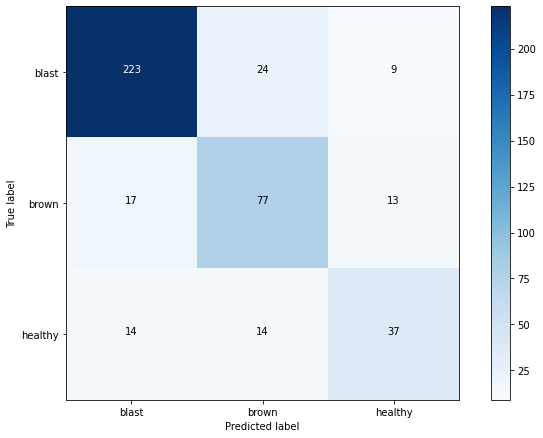

In [24]:
classes = ['blast', 'brown', 'healthy']
plot_confusion_matrix(confusion_matrix(val_label, val_pred), target_names=classes)

In [25]:
test_pred = test_model(device, resnet50_1, test_loader)

In [26]:
ss.loc[:,'Label'] = test_pred
ss.to_csv('result_resnet50-v5.csv', index=False)
display(ss)

,Image_id,Label
0,id_heszk4wzl8.jpg,1
1,id_265q4z1ajs.jpg,1
2,id_ob0maoob4f.jpg,0
3,id_h7uxylua90.jpg,0
4,id_orl0slzk06.jpg,1
...,...,...
529,id_31p3zk5bof.jpg,0
530,id_i6x683j16r.jpg,0
531,id_79ur22z995.jpg,0
532,id_bhtpzg75z9.jpg,2


### Score: 0.78464